In [ ]:
print("Installing yfinance...")
!pip install yfinance
print("yfinance installed successfully.")

Installing yfinance...
yfinance installed successfully.


In [ ]:
import yfinance as yf

ticker_symbol = 'AAPL'
stock = yf.Ticker(ticker_symbol)

current_stock_price = stock.info['currentPrice']
print(f"Current stock price for {ticker_symbol}: ${current_stock_price:.2f}")

expiration_dates = stock.options
print(f"Available expiration dates: {expiration_dates}")

option_chains = {}
for date in expiration_dates:
    opt = stock.option_chain(date)
    option_chains[date] = {
        'calls': opt.calls,
        'puts': opt.puts
    }

print(f"Fetched option chains for {len(expiration_dates)} dates.")

if expiration_dates:
    first_date = expiration_dates[0]
    print(f"\nSample Calls for {first_date}:")
    print(option_chains[first_date]['calls'].head())
    print(f"\nSample Puts for {first_date}:")
    print(option_chains[first_date]['puts'].head())

Current stock price for AAPL: $278.78
Available expiration dates: ('2025-12-12', '2025-12-19', '2025-12-26', '2026-01-02', '2026-01-09', '2026-01-16', '2026-01-23', '2026-02-20', '2026-03-20', '2026-04-17', '2026-05-15', '2026-06-18', '2026-07-17', '2026-08-21', '2026-09-18', '2026-12-18', '2027-01-15', '2027-06-17', '2027-12-17', '2028-01-21', '2028-03-17')
Fetched option chains for 21 dates.

Sample Calls for 2025-12-12:
        contractSymbol             lastTradeDate  strike  lastPrice  bid  ask  \
0  AAPL251212C00120000 2025-11-14 19:27:23+00:00   120.0     154.48  0.0  0.0   
1  AAPL251212C00150000 2025-12-08 15:45:43+00:00   150.0     127.50  0.0  0.0   
2  AAPL251212C00155000 2025-11-28 17:50:00+00:00   155.0     123.05  0.0  0.0   
3  AAPL251212C00160000 2025-12-09 17:37:02+00:00   160.0     118.22  0.0  0.0   
4  AAPL251212C00170000 2025-12-04 14:43:58+00:00   170.0     113.23  0.0  0.0   

   change  percentChange  volume  openInterest  impliedVolatility  inTheMoney  \
0    

In [ ]:
import datetime

# 1. Choose a specific expiration date
chosen_date_str = expiration_dates[2]
print(f"Chosen Expiration Date: {chosen_date_str}")

# 2. Select either calls or puts
option_type = "call"
selected_options_df = option_chains[chosen_date_str]['calls']

# 3. Identify an at-the-money (ATM) option
S = current_stock_price
atm_option = selected_options_df.iloc[(selected_options_df['strike'] - S).abs().argsort()[:1]]

# Extract the strike price (K) of this ATM option
K = atm_option['strike'].iloc[0]

print(f"Current Stock Price (S): ${S:.2f}")
print(f"Selected Option Strike Price (K): ${K:.2f}")

# 4. Calculate the time to maturity (T) in years
expiration_datetime = datetime.datetime.strptime(chosen_date_str, '%Y-%m-%d')
current_datetime = datetime.datetime.now()
days_to_maturity = (expiration_datetime - current_datetime).days
T = days_to_maturity / 365.25 # Account for leap years
print(f"Time to Maturity (T) in years: {T:.4f}")

# 5. Define assumed values for the risk-free rate (r) and volatility (sigma)
r = 0.05 # Risk-free rate
sigma = 0.20 # Volatility
print(f"Assumed Risk-free Rate (r): {r}")
print(f"Assumed Volatility (sigma): {sigma}")
print(f"Option Type: {option_type}")

Chosen Expiration Date: 2025-12-26
Current Stock Price (S): $278.78
Selected Option Strike Price (K): $280.00
Time to Maturity (T) in years: 0.0383
Assumed Risk-free Rate (r): 0.05
Assumed Volatility (sigma): 0.2
Option Type: call


In [ ]:
import numpy as np
from scipy.stats import norm

def black_scholes_price(S, K, T, r, sigma, option_type):
    # S: underlying stock price
    # K: strike price
    # T: time to maturity (in years)
    # r: risk-free rate (annual)
    # sigma: volatility (annual)
    # option_type: 'call' or 'put'

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    return price

# Calculate Black-Scholes European Option Price
bs_option_price = black_scholes_price(S, K, T, r, sigma, option_type)
print(f"Black-Scholes European Option Price ({option_type}): ${bs_option_price:.2f}")

Black-Scholes European Option Price (call): $4.03


In [ ]:
import numpy as np

def binomial_american_option(S, K, T, r, sigma, steps, option_type):
    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Initialize stock price tree
    stock_tree = np.zeros((steps + 1, steps + 1))
    for j in range(steps + 1):
        for i in range(j + 1):
            stock_tree[i, j] = S * (u**i) * (d**(j - i))

    # Initialize option price tree
    option_tree = np.zeros((steps + 1, steps + 1))

    # Calculate option value at maturity
    for i in range(steps + 1):
        if option_type == 'call':
            option_tree[i, steps] = max(0, stock_tree[i, steps] - K)
        elif option_type == 'put':
            option_tree[i, steps] = max(0, K - stock_tree[i, steps])

    # Work backwards through the tree
    for j in range(steps - 1, -1, -1):
        for i in range(j + 1):
            # Option value if not exercised early
            option_value_no_early_exercise = np.exp(-r * dt) * (p * option_tree[i + 1, j + 1] + (1 - p) * option_tree[i, j + 1])

            # Option value if exercised early
            if option_type == 'call':
                option_value_early_exercise = max(0, stock_tree[i, j] - K)
            elif option_type == 'put':
                option_value_early_exercise = max(0, K - stock_tree[i, j])

            # American option value is the max of early exercise and no early exercise
            option_tree[i, j] = max(option_value_no_early_exercise, option_value_early_exercise)

    return option_tree[0, 0]

# Calculate Binomial American Option Price
amer_option_price = binomial_american_option(S, K, T, r, sigma, steps=200, option_type=option_type)
print(f"Binomial American Option Price ({option_type}): ${amer_option_price:.2f}")

Binomial American Option Price (call): $4.03


In [ ]:
import numpy as np

def monte_carlo_option_price(S, K, T, r, sigma, num_simulations, num_steps, option_type):
    dt = T / num_steps
    paths = np.zeros((num_simulations, num_steps + 1))
    paths[:, 0] = S

    for t in range(1, num_steps + 1):
        z = np.random.standard_normal(num_simulations)
        paths[:, t] = paths[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)

    if option_type == 'call':
        payoffs = np.maximum(0, paths[:, -1] - K)
    elif option_type == 'put':
        payoffs = np.maximum(0, K - paths[:, -1])
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    option_price = np.exp(-r * T) * np.mean(payoffs)
    return option_price

# Monte Carlo simulation parameters
num_simulations = 10000
num_steps = 252

# Calculate Monte Carlo European Option Price
mc_price = monte_carlo_option_price(S, K, T, r, sigma, num_simulations, num_steps, option_type)

print(f"Monte Carlo European Option Price ({option_type}): ${mc_price:.2f}")

Monte Carlo European Option Price (call): $4.06


In [ ]:
# Get market price of the chosen ATM option
market_price = atm_option['lastPrice'].iloc[0]
print(f"Market Price of the ATM Option: ${market_price:.2f}")

Market Price of the ATM Option: $3.85


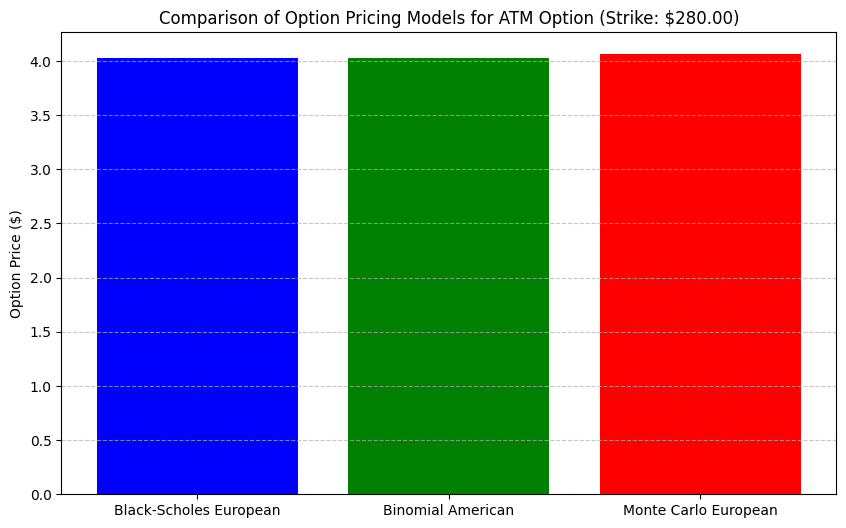

Bar chart comparing option pricing models generated.


In [ ]:
import matplotlib.pyplot as plt

# Define labels and option prices for the bar chart
model_labels = ['Black-Scholes European', 'Binomial American', 'Monte Carlo European']
option_prices = [bs_option_price, amer_option_price, mc_price]

# Generate a bar chart comparing option pricing models
plt.figure(figsize=(10, 6))
plt.bar(model_labels, option_prices, color=['blue', 'green', 'red'])

# Add a title and label to the chart
plt.title(f'Comparison of Option Pricing Models for ATM Option (Strike: ${K:.2f})')
plt.ylabel('Option Price ($)')

# Display the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("Bar chart comparing option pricing models generated.")

In [ ]:
import numpy as np
from scipy.stats import norm

def black_scholes_greeks(S, K, T, r, sigma, option_type):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        delta = norm.cdf(d1)
        gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
        vega = S * norm.pdf(d1) * np.sqrt(T)
        theta = - (S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2)
        rho = K * T * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        delta = norm.cdf(d1) - 1
        gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
        vega = S * norm.pdf(d1) * np.sqrt(T)
        theta = - (S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) + r * K * np.exp(-r * T) * norm.cdf(-d2)
        rho = -K * T * np.exp(-r * T) * norm.cdf(-d2)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    return {
        'delta': delta,
        'gamma': gamma,
        'vega': vega,
        'theta': theta,
        'rho': rho
    }

# Calculate Black-Scholes Greeks
greeks_result = black_scholes_greeks(S, K, T, r, sigma, option_type)
print(f"Black-Scholes Greeks for {option_type.capitalize()} Option:")
for greek, value in greeks_result.items():
    print(f"  {greek.capitalize()}: {value:.4f}")

Black-Scholes Greeks for Call Option:
  Delta: 0.4829
  Gamma: 0.0365
  Vega: 21.7540
  Theta: -63.2838
  Rho: 5.0052


In [ ]:
# Apply the black_scholes_greeks function to each row of the iv_df DataFrame
greeks_series = iv_df.apply(
    lambda row: black_scholes_greeks(
        S=S,
        K=row['strike'],
        T=T,
        r=r,
        sigma=row['implied_volatility'],
        option_type=row['type'].lower()
    ),
    axis=1
)

# Convert the Series of dictionaries into a new DataFrame called greeks_df
greeks_df = pd.DataFrame(greeks_series.tolist())

# Identify Greek column names that might already exist in iv_df
greek_column_names = greeks_df.columns.tolist()

# Drop existing Greek columns from iv_df to prevent duplicates from repeated execution
iv_df = iv_df.drop(columns=[col for col in greek_column_names if col in iv_df.columns], errors='ignore')

# Concatenate greeks_df with the original iv_df along axis=1
iv_df = pd.concat([iv_df, greeks_df], axis=1)

print("Calculated Greeks for all options and merged them into iv_df.")
print(iv_df.head())

Calculated Greeks for all options and merged them into iv_df.
   strike  implied_volatility  type     delta     gamma      vega       theta  \
0   110.0            2.662845  Call  0.979726  0.000337  2.673313  -98.001219   
1   125.0            3.366497  Call  0.939362  0.000654  6.555704 -292.965871   
2   155.0            2.693335  Call  0.916283  0.001047  8.396690 -301.218911   
3   170.0            1.665640  Call  0.954075  0.001060  5.258790 -122.007171   
4   180.0            2.059462  Call  0.901706  0.001542  9.458842 -261.412118   

        rho  
0  3.941389  
1  3.889544  
2  4.762927  
3  5.937954  
4  5.596843  


In [ ]:
from scipy.optimize import brentq

def objective_function_iv(sigma, S, K, T, r, market_price, option_type):
    # Calculate Black-Scholes price for a given volatility
    model_price = black_scholes_price(S, K, T, r, sigma, option_type)
    # Return the difference between the model price and the market price
    return model_price - market_price

# Use brentq to find the implied volatility from the market price
implied_volatility = brentq(objective_function_iv, 0.001, 5.0, args=(S, K, T, r, market_price, option_type))

print(f"Calculated Implied Volatility (IV): {implied_volatility:.4f}")

Calculated Implied Volatility (IV): 0.1919


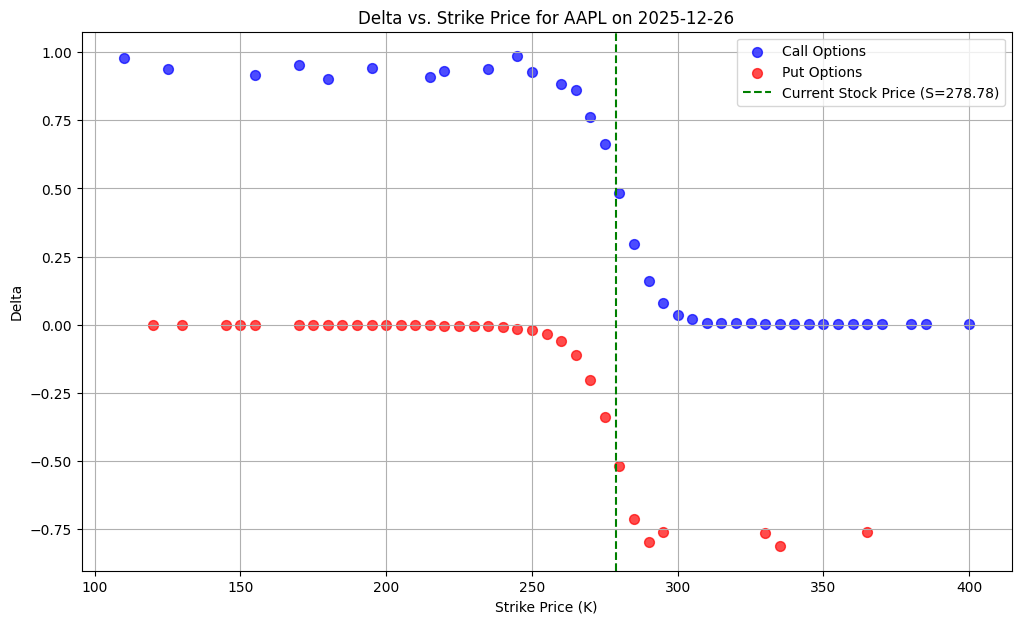

Delta vs. Strike Price plot generated.


In [ ]:
# Filter iv_df for call and put options
calls_iv_df = iv_df[iv_df['type'] == 'Call']
puts_iv_df = iv_df[iv_df['type'] == 'Put']

# Create the scatter plot for Delta
plt.figure(figsize=(12, 7))

# Plot Delta for Call Options
plt.scatter(
    calls_iv_df['strike'],
    calls_iv_df['delta'], # Access the 'delta' column directly
    label='Call Options',
    alpha=0.7,
    color='blue',
    s=50
)

# Plot Delta for Put Options
plt.scatter(
    puts_iv_df['strike'],
    puts_iv_df['delta'], # Access the 'delta' column directly
    label='Put Options',
    alpha=0.7,
    color='red',
    s=50
)

# Add a vertical line for the current stock price
plt.axvline(S, color='green', linestyle='--', label=f'Current Stock Price (S={S:.2f})')

# Set title and labels
plt.title(f'Delta vs. Strike Price for {ticker_symbol} on {chosen_date_str}')
plt.xlabel('Strike Price (K)')
plt.ylabel('Delta')

# Add legend and grid
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

print("Delta vs. Strike Price plot generated.")

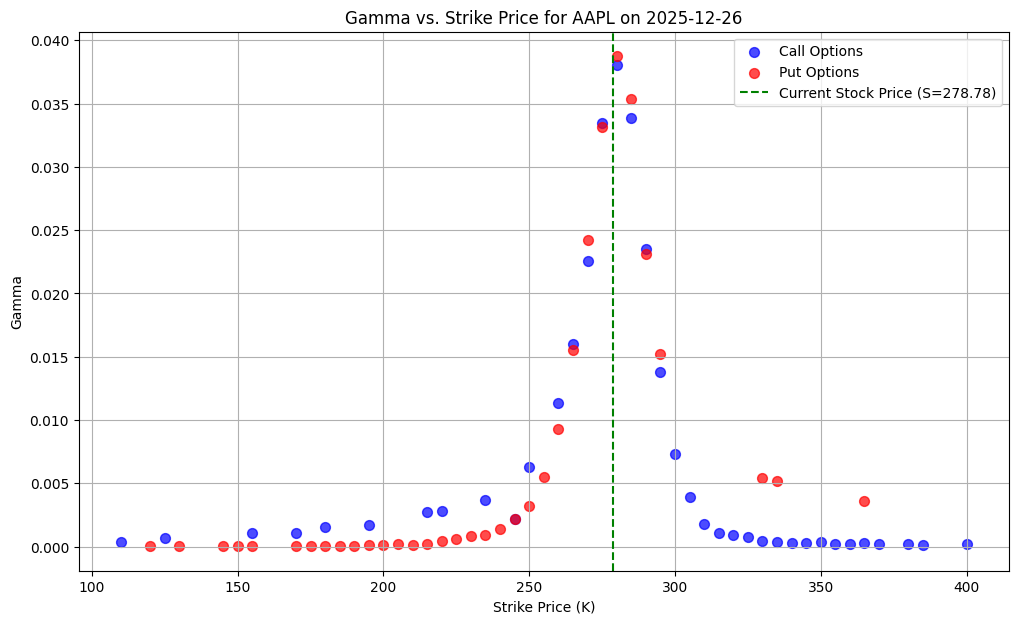

Gamma vs. Strike Price plot generated.


In [ ]:
# Filter iv_df for call and put options
calls_iv_df = iv_df[iv_df['type'] == 'Call']
puts_iv_df = iv_df[iv_df['type'] == 'Put']

# Create the scatter plot for Gamma
plt.figure(figsize=(12, 7))

# Plot Gamma for Call Options
plt.scatter(
    calls_iv_df['strike'],
    calls_iv_df['gamma'], # Access the 'gamma' column directly
    label='Call Options',
    alpha=0.7,
    color='blue',
    s=50
)

# Plot Gamma for Put Options
plt.scatter(
    puts_iv_df['strike'],
    puts_iv_df['gamma'], # Access the 'gamma' column directly
    label='Put Options',
    alpha=0.7,
    color='red',
    s=50
)

# Add a vertical line for the current stock price
plt.axvline(S, color='green', linestyle='--', label=f'Current Stock Price (S={S:.2f})')

# Set title and labels
plt.title(f'Gamma vs. Strike Price for {ticker_symbol} on {chosen_date_str}')
plt.xlabel('Strike Price (K)')
plt.ylabel('Gamma')

# Add legend and grid
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

print("Gamma vs. Strike Price plot generated.")

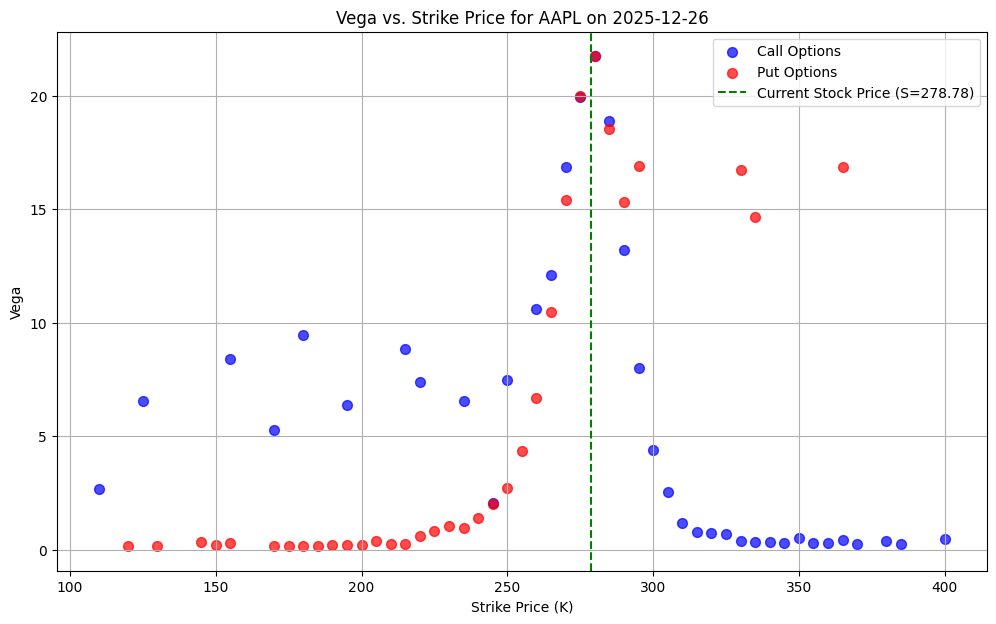

Vega vs. Strike Price plot generated.


In [ ]:
# Filter iv_df for call and put options
calls_iv_df = iv_df[iv_df['type'] == 'Call']
puts_iv_df = iv_df[iv_df['type'] == 'Put']

# Create the scatter plot for Vega
plt.figure(figsize=(12, 7))

# Plot Vega for Call Options
plt.scatter(
    calls_iv_df['strike'],
    calls_iv_df['vega'], # Access the 'vega' column directly
    label='Call Options',
    alpha=0.7,
    color='blue',
    s=50
)

# Plot Vega for Put Options
plt.scatter(
    puts_iv_df['strike'],
    puts_iv_df['vega'], # Access the 'vega' column directly
    label='Put Options',
    alpha=0.7,
    color='red',
    s=50
)

# Add a vertical line for the current stock price
plt.axvline(S, color='green', linestyle='--', label=f'Current Stock Price (S={S:.2f})')

# Set title and labels
plt.title(f'Vega vs. Strike Price for {ticker_symbol} on {chosen_date_str}')
plt.xlabel('Strike Price (K)')
plt.ylabel('Vega')

# Add legend and grid
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

print("Vega vs. Strike Price plot generated.")

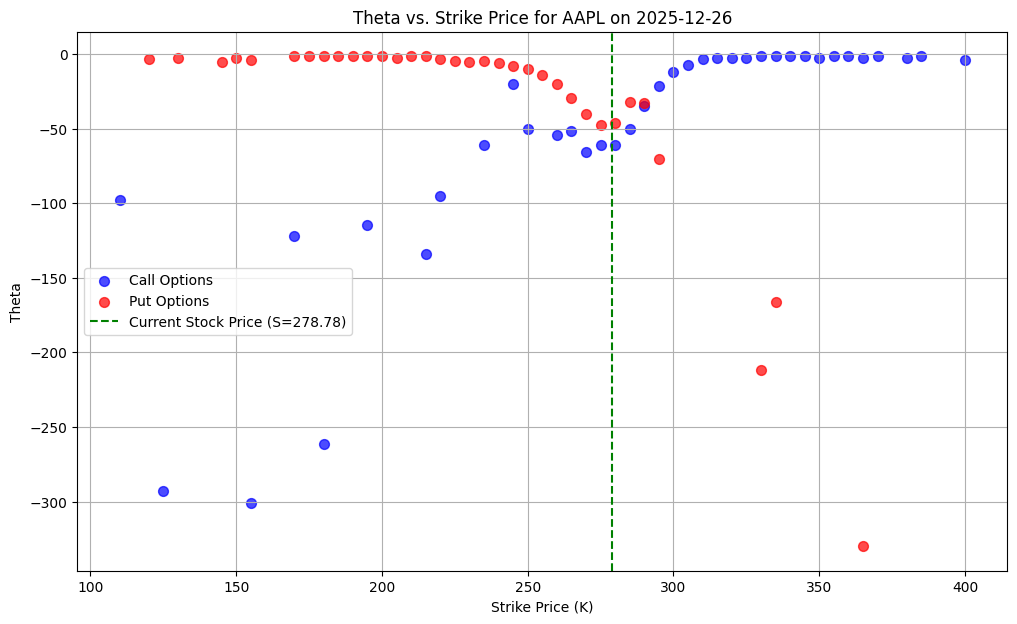

Theta vs. Strike Price plot generated.


In [ ]:
# Filter iv_df for call and put options
calls_iv_df = iv_df[iv_df['type'] == 'Call']
puts_iv_df = iv_df[iv_df['type'] == 'Put']

# Create the scatter plot for Theta
plt.figure(figsize=(12, 7))

# Plot Theta for Call Options
plt.scatter(
    calls_iv_df['strike'],
    calls_iv_df[['theta']].iloc[:, -1], # Select all 'theta' columns, then the last one
    label='Call Options',
    alpha=0.7,
    color='blue',
    s=50
)

# Plot Theta for Put Options
plt.scatter(
    puts_iv_df['strike'],
    puts_iv_df[['theta']].iloc[:, -1], # Select all 'theta' columns, then the last one
    label='Put Options',
    alpha=0.7,
    color='red',
    s=50
)

# Add a vertical line for the current stock price
plt.axvline(S, color='green', linestyle='--', label=f'Current Stock Price (S={S:.2f})')

# Set title and labels
plt.title(f'Theta vs. Strike Price for {ticker_symbol} on {chosen_date_str}')
plt.xlabel('Strike Price (K)')
plt.ylabel('Theta')

# Add legend and grid
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

print("Theta vs. Strike Price plot generated.")

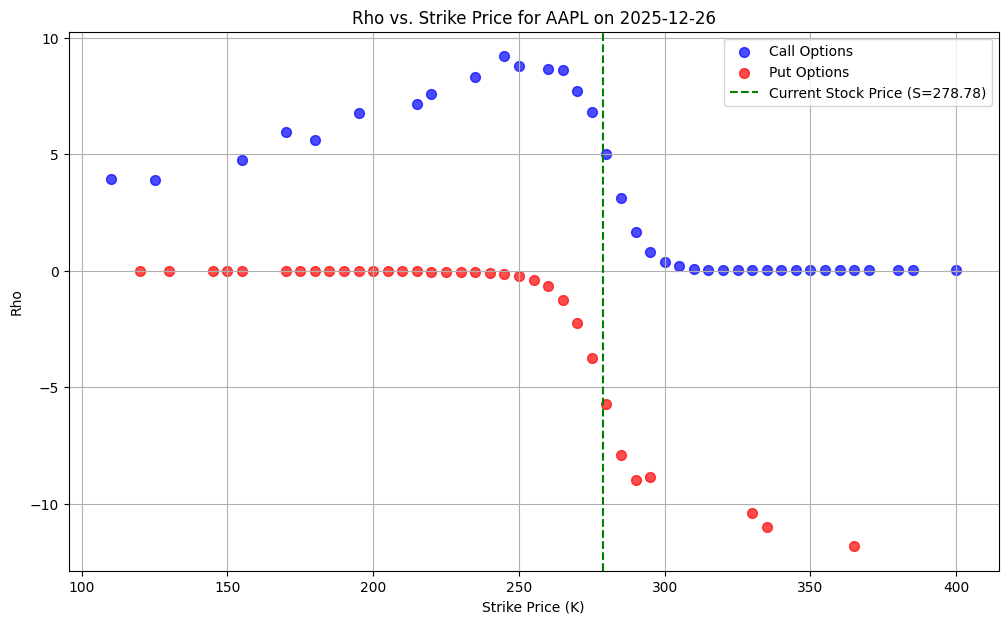

Rho vs. Strike Price plot generated.


In [ ]:
# Filter iv_df for call and put options
calls_iv_df = iv_df[iv_df['type'] == 'Call']
puts_iv_df = iv_df[iv_df['type'] == 'Put']

# Create the scatter plot for Rho
plt.figure(figsize=(12, 7))

# Plot Rho for Call Options
plt.scatter(
    calls_iv_df['strike'],
    calls_iv_df['rho'],
    label='Call Options',
    alpha=0.7,
    color='blue',
    s=50
)

# Plot Rho for Put Options
plt.scatter(
    puts_iv_df['strike'],
    puts_iv_df['rho'],
    label='Put Options',
    alpha=0.7,
    color='red',
    s=50
)

# Add a vertical line for the current stock price
plt.axvline(S, color='green', linestyle='--', label=f'Current Stock Price (S={S:.2f})')

# Set title and labels
plt.title(f'Rho vs. Strike Price for {ticker_symbol} on {chosen_date_str}')
plt.xlabel('Strike Price (K)')
plt.ylabel('Rho')

# Add legend and grid
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

print("Rho vs. Strike Price plot generated.")

Calculated Implied Volatilities for 71 options.


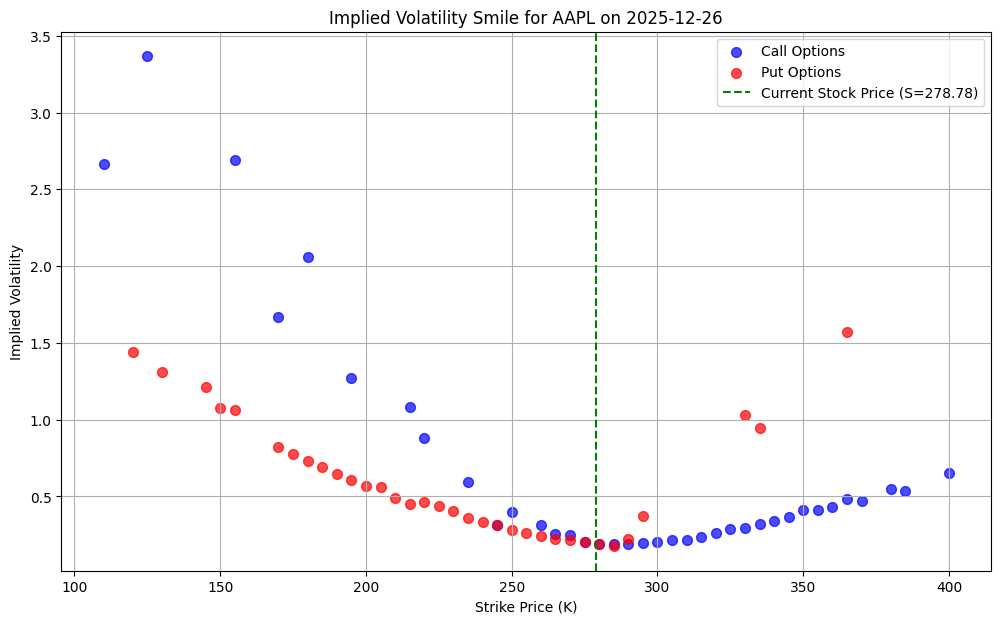

Implied Volatility Smile plot generated.


In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import brentq

def calculate_implied_volatility(market_price, S, K, T, r, option_type):
    # Ensure T is not zero or negative, as it causes issues in Black-Scholes and implied volatility calculations
    if T <= 1e-6: # Use a small epsilon to check for near-zero T
        return np.nan
    try:
        # Use brentq to find the implied volatility
        # The objective_function_iv is assumed to be defined in a previous cell
        iv = brentq(objective_function_iv, 0.001, 5.0, args=(S, K, T, r, market_price, option_type))
        return iv
    except ValueError:
        # If brentq fails to find a root (e.g., market_price is too far off, or no real root exists)
        return np.nan

# Prepare data for plotting implied volatilities for all options
iv_data = []

# Process Call Options: calculate implied volatility and append to iv_data
calls_df = option_chains[chosen_date_str]['calls'].copy()
calls_df['impliedVolatilityCalculated'] = calls_df.apply(
    lambda row: calculate_implied_volatility(row['lastPrice'], S, row['strike'], T, r, 'call'),
    axis=1
)
for _, row in calls_df.iterrows():
    if not pd.isna(row['impliedVolatilityCalculated']):
        iv_data.append({'strike': row['strike'], 'implied_volatility': row['impliedVolatilityCalculated'], 'type': 'Call'})

# Process Put Options: calculate implied volatility and append to iv_data
puts_df = option_chains[chosen_date_str]['puts'].copy()
puts_df['impliedVolatilityCalculated'] = puts_df.apply(
    lambda row: calculate_implied_volatility(row['lastPrice'], S, row['strike'], T, r, 'put'),
    axis=1
)
for _, row in puts_df.iterrows():
    if not pd.isna(row['impliedVolatilityCalculated']):
        iv_data.append({'strike': row['strike'], 'implied_volatility': row['impliedVolatilityCalculated'], 'type': 'Put'})

iv_df = pd.DataFrame(iv_data)

print(f"Calculated Implied Volatilities for {len(iv_df)} options.")

# Plotting the Implied Volatility Smile
plt.figure(figsize=(12, 7))

# Plot Calls
if not iv_df[iv_df['type'] == 'Call'].empty:
    plt.scatter(iv_df[iv_df['type'] == 'Call']['strike'], iv_df[iv_df['type'] == 'Call']['implied_volatility'],
                label='Call Options', alpha=0.7, color='blue', s=50)

# Plot Puts
if not iv_df[iv_df['type'] == 'Put'].empty:
    plt.scatter(iv_df[iv_df['type'] == 'Put']['strike'], iv_df[iv_df['type'] == 'Put']['implied_volatility'],
                label='Put Options', alpha=0.7, color='red', s=50)

plt.axvline(S, color='green', linestyle='--', label=f'Current Stock Price (S={S:.2f})')

plt.title(f'Implied Volatility Smile for {ticker_symbol} on {chosen_date_str}')
plt.xlabel('Strike Price (K)')
plt.ylabel('Implied Volatility')
plt.grid(True)
plt.legend()
plt.show()

print("Implied Volatility Smile plot generated.")

In [ ]:
print(f"\n--- Option Analysis Results ---")
print(f"Contextual Parameters:")
print(f"  Current Stock Price (S): ${S:.2f}")
print(f"  Strike Price (K): ${K:.2f}")
print(f"  Time to Maturity (T) in years: {T:.4f}")
print(f"  Risk-free Rate (r): {r}")
print(f"  Initial Assumed Volatility (sigma): {sigma}")
print(f"  Option Type: {option_type}")

print(f"\nCalculated Values:")
print(f"  Black-Scholes European Option Price: ${bs_option_price:.2f}")
print(f"  Binomial American Option Price: ${amer_option_price:.2f}")
print(f"  Monte Carlo European Option Price: ${mc_price:.2f}")
print(f"  Implied Volatility (from market price ${market_price:.2f}): {implied_volatility:.4f}")

print(f"\nBlack-Scholes Greeks for {option_type.capitalize()} Option:")
for greek, value in greeks_result.items():
    print(f"  {greek.capitalize()}: {value:.4f}")


--- Option Analysis Results ---
Contextual Parameters:
  Current Stock Price (S): $278.78
  Strike Price (K): $280.00
  Time to Maturity (T) in years: 0.0383
  Risk-free Rate (r): 0.05
  Initial Assumed Volatility (sigma): 0.2
  Option Type: call

Calculated Values:
  Black-Scholes European Option Price: $4.03
  Binomial American Option Price: $4.03
  Monte Carlo European Option Price: $4.06
  Implied Volatility (from market price $3.85): 0.1919

Black-Scholes Greeks for Call Option:
  Delta: 0.4829
  Gamma: 0.0365
  Vega: 21.7540
  Theta: -63.2838
  Rho: 5.0052


In [ ]:
import pandas as pd

# Separate call and put options for potential separate analysis or processing
calls_iv_full = iv_data_full[iv_data_full['option_type'] == 'Call'].copy()
puts_iv_full = iv_data_full[iv_data_full['option_type'] == 'Put'].copy()

# Print information about the separated dataframes
print(f"Number of call options for interpolation: {len(calls_iv_full)}")
print(f"Number of put options for interpolation: {len(puts_iv_full)}")

# Display the first few rows of the separated dataframes
print("\nFirst 5 rows of Call Options IV data:")
print(calls_iv_full.head())
print("\nFirst 5 rows of Put Options IV data:")
print(puts_iv_full.head())

# Prepare data for interpolation (X, Y, Z for both calls and puts)
# For calls
X_calls = calls_iv_full['strike']
Y_calls = calls_iv_full['time_to_maturity']
Z_calls = calls_iv_full['implied_volatility']

# For puts
X_puts = puts_iv_full['strike']
Y_puts = puts_iv_full['time_to_maturity']
Z_puts = puts_iv_full['implied_volatility']

print("\nData prepared for 2D surface interpolation (strike, time to maturity, implied volatility).")

Number of call options for interpolation: 852
Number of put options for interpolation: 990

First 5 rows of Call Options IV data:
  expiration_date  strike  time_to_maturity option_type  implied_volatility
0      2025-12-19    85.0          0.019165        Call            4.755974
1      2025-12-19   140.0          0.019165        Call            2.301198
2      2025-12-19   145.0          0.019165        Call            2.502328
3      2025-12-19   150.0          0.019165        Call            2.384483
4      2025-12-19   155.0          0.019165        Call            2.020977

First 5 rows of Put Options IV data:
   expiration_date  strike  time_to_maturity option_type  implied_volatility
60      2025-12-19    35.0          0.019165         Put            4.641090
61      2025-12-19    40.0          0.019165         Put            4.340597
62      2025-12-19    45.0          0.019165         Put            4.077093
63      2025-12-19    50.0          0.019165         Put            

In [ ]:
from scipy.ndimage import gaussian_filter

# --- Gaussian Kernel Smoothing for Calls ---
# Replace NaN values with a reasonable estimate or 0 for smoothing, then mask them again later
interp_iv_calls_filled = np.nan_to_num(interp_iv_calls, nan=np.nanmean(interp_iv_calls))
smoothed_iv_calls = gaussian_filter(interp_iv_calls_filled, sigma=2)
# Where the original interpolated values were NaN, set the smoothed values back to NaN
smoothed_iv_calls[np.isnan(interp_iv_calls)] = np.nan

print("Gaussian kernel smoothing for call options completed.")

# --- Gaussian Kernel Smoothing for Puts ---
interp_iv_puts_filled = np.nan_to_num(interp_iv_puts, nan=np.nanmean(interp_iv_puts))
smoothed_iv_puts = gaussian_filter(interp_iv_puts_filled, sigma=2)
smoothed_iv_puts[np.isnan(interp_iv_puts)] = np.nan

print("Gaussian kernel smoothing for put options completed.")

print(f"Shape of smoothed IV grid for calls: {smoothed_iv_calls.shape}")
print(f"Shape of smoothed IV grid for puts: {smoothed_iv_puts.shape}")

Gaussian kernel smoothing for call options completed.
Gaussian kernel smoothing for put options completed.
Shape of smoothed IV grid for calls: (50, 100)
Shape of smoothed IV grid for puts: (50, 100)


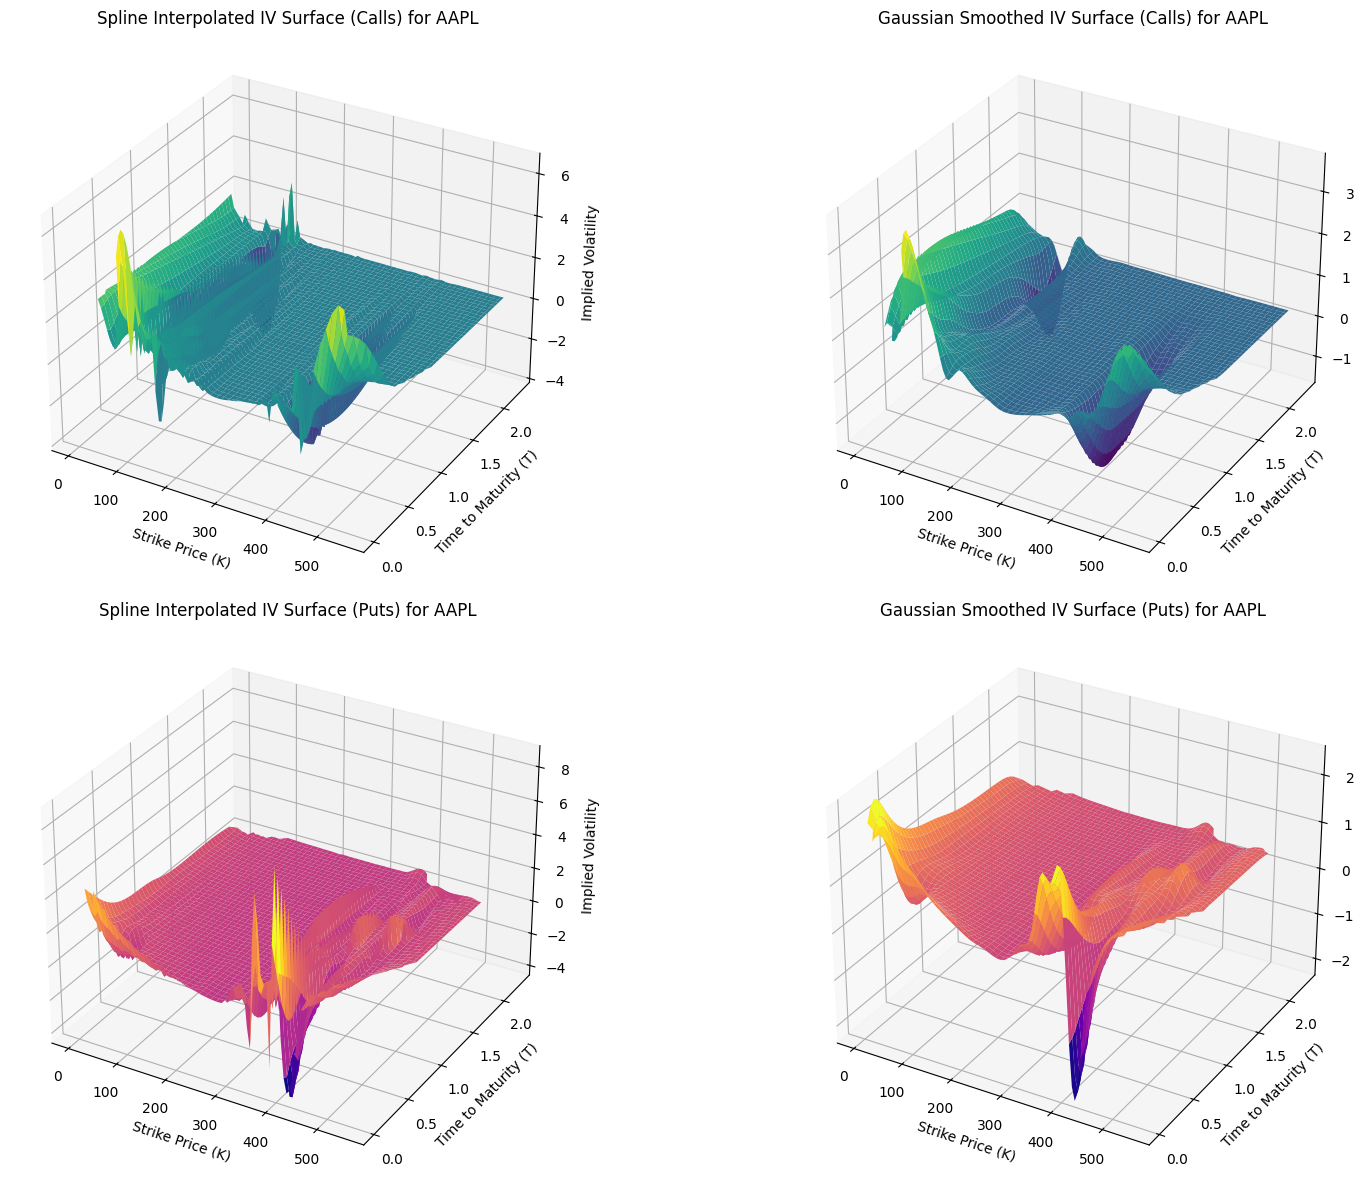

3D plots of spline interpolated and Gaussian smoothed implied volatility surfaces generated.


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a figure with subplots for 3D visualization
fig = plt.figure(figsize=(18, 12))

# --- Plot 1: Spline Interpolated Calls ---
ax1 = fig.add_subplot(221, projection='3d')
# Pass the original grid and the interpolated values, plot_surface handles NaNs
ax1.plot_surface(strike_grid,
                 ttm_grid,
                 interp_iv_calls, cmap='viridis', edgecolor='none')
ax1.set_title(f'Spline Interpolated IV Surface (Calls) for {ticker_symbol}')
ax1.set_xlabel('Strike Price (K)')
ax1.set_ylabel('Time to Maturity (T)')
ax1.set_zlabel('Implied Volatility')

# --- Plot 2: Gaussian Smoothed Calls ---
ax2 = fig.add_subplot(222, projection='3d')
# Pass the original grid and the smoothed values
ax2.plot_surface(strike_grid,
                 ttm_grid,
                 smoothed_iv_calls, cmap='viridis', edgecolor='none')
ax2.set_title(f'Gaussian Smoothed IV Surface (Calls) for {ticker_symbol}')
ax2.set_xlabel('Strike Price (K)')
ax2.set_ylabel('Time to Maturity (T)')
ax2.set_zlabel('Implied Volatility')

# --- Plot 3: Spline Interpolated Puts ---
ax3 = fig.add_subplot(223, projection='3d')
# Pass the original grid and the interpolated values
ax3.plot_surface(strike_grid,
                 ttm_grid,
                 interp_iv_puts, cmap='plasma', edgecolor='none')
ax3.set_title(f'Spline Interpolated IV Surface (Puts) for {ticker_symbol}')
ax3.set_xlabel('Strike Price (K)')
ax3.set_ylabel('Time to Maturity (T)')
ax3.set_zlabel('Implied Volatility')

# --- Plot 4: Gaussian Smoothed Puts ---
ax4 = fig.add_subplot(224, projection='3d')
# Pass the original grid and the smoothed values
ax4.plot_surface(strike_grid,
                 ttm_grid,
                 smoothed_iv_puts, cmap='plasma', edgecolor='none')
ax4.set_title(f'Gaussian Smoothed IV Surface (Puts) for {ticker_symbol}')
ax4.set_xlabel('Strike Price (K)')
ax4.set_ylabel('Time to Maturity (T)')
ax4.set_zlabel('Implied Volatility')

plt.tight_layout()
plt.show()

print("3D plots of spline interpolated and Gaussian smoothed implied volatility surfaces generated.")